In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os

In [9]:
# Load data from Excel file
main_dir= "/home/ulaval.ca/lesee/projects/Project-CNET/"

data = pd.read_csv(os.path.join(main_dir,'results/data_combat/combat_harmonized_features_nested_cnet_updated_bw_0_05_ND_new.csv'))


data_features = data.drop('PatientName', axis=1)

df_combat = pd.read_csv(os.path.join(main_dir,'data/radiomics_CNET_updated_bin_0_05_batch_clinical_new.csv'))

# Remove the first row (index 0)
#data_combat = data_combat.iloc[1:]

# Separate the slice thicknesses from the features
combat_cols = ['model', 'kernel','slice_thickness']
data_combat = df_combat[combat_cols]
#slice_thicknesses = data_combat['kernel']

#Identify columns that contain strings
string_columns = [col for col in features.columns if features[col].apply(lambda x: isinstance(x, str)).any()]

#Drop columns that contain strings
data_features_cleaned = data_features.drop(columns=string_columns)
                        

In [10]:
value_counts = data_combat['slice_thickness'].value_counts()
# Identify values that occur exactly once
print(value_counts.index)

Int64Index([2, 1], dtype='int64')


In [11]:
#print(data_combat)
#print(np.shape(features))
#print(np.shape(features_cleaned))

In [12]:
# Separate the slice thicknesses from the features
batch_slice = data_combat['slice_thickness']
batch_kernel = data_combat['kernel']
batch_model = data_combat['model']

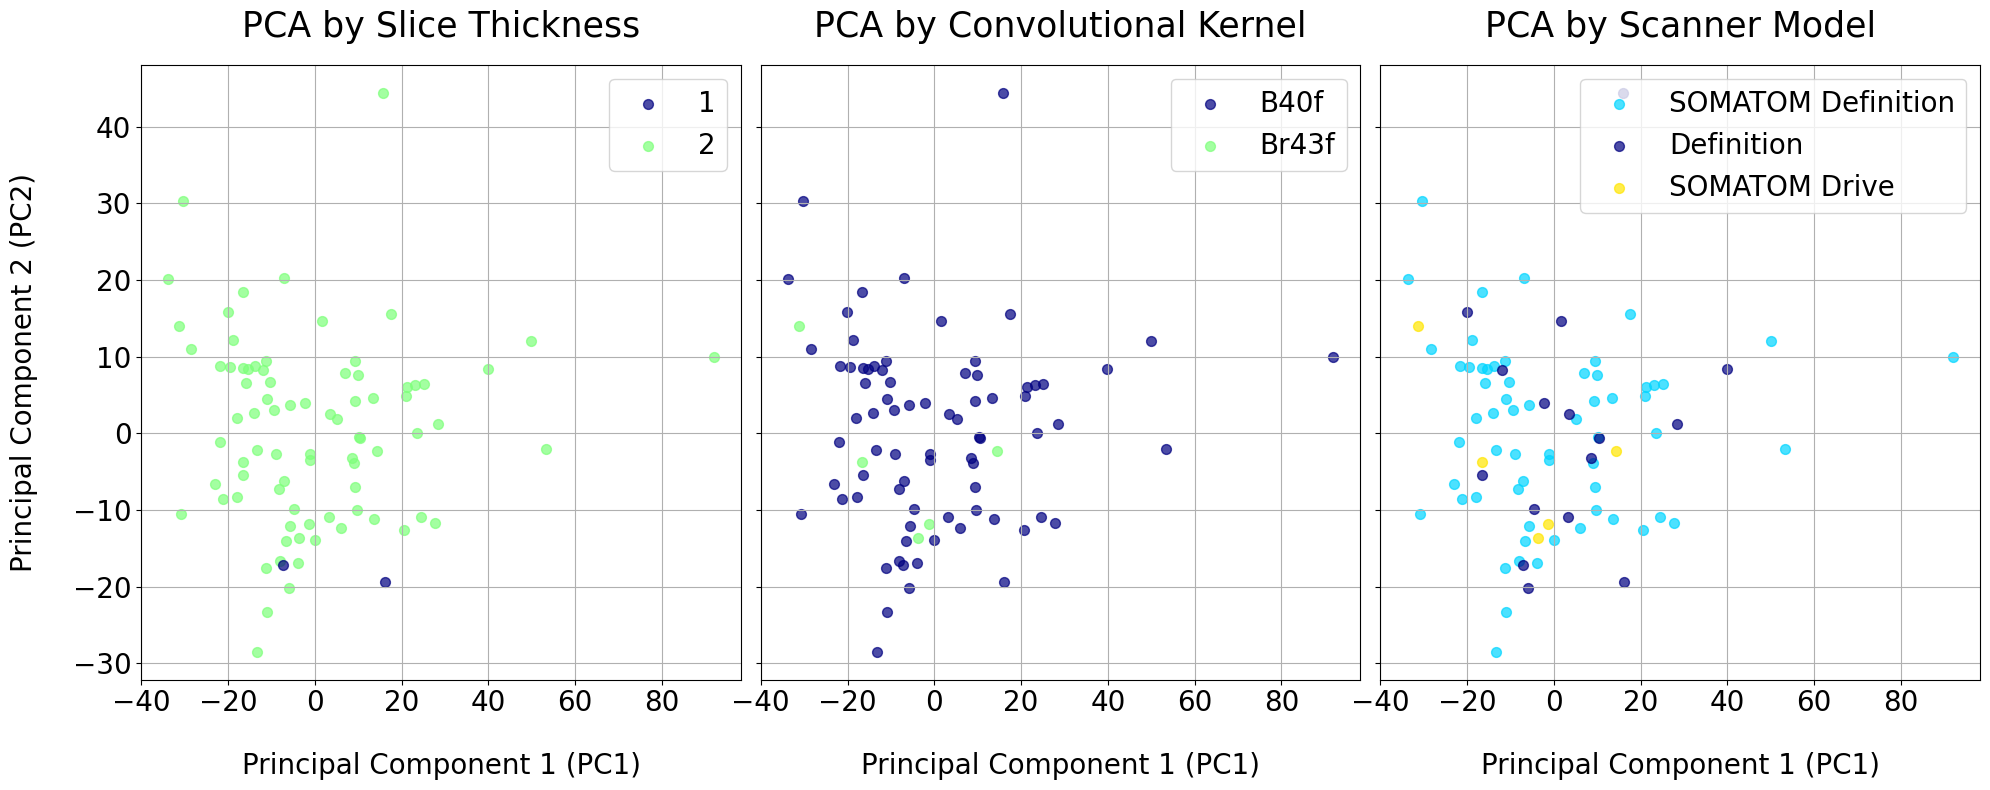

In [15]:
# Assuming data_features, batch, and kernel data are already defined
scaler = StandardScaler()
standardized_features = scaler.fit_transform(data_features_cleaned)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(standardized_features)


pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
pca_df['slice_thickness'] = batch_slice  # Assume 'batch_TC' contains thickness categories
pca_df['kernel'] = batch_kernel       # Assume 'batch_KT' contains kernel type data
pca_df['model'] = batch_model       # Assume 'batch_KT' contains kernel type data

def parse_range(text):
    """Parse the numeric part of the range from text and return the starting value as a float."""
    # This extracts the numeric value before the hyphen and removes the "mm"
    return float(text.split('-')[0].strip())

# Define the plotting function
def plot_pca_by_category(df, category, ax, title, show_y_labels=True, point_size=50):
    unique_categories = sorted(df[category].unique())  # Sort categories
    colors = {cat: plt.cm.jet(i / len(unique_categories)) for i, cat in enumerate(unique_categories)}
    category_counts = df[category].value_counts()
    # Sort categories from most to least populated
    sorted_categories = category_counts.sort_values(ascending=False).index.tolist()
    
    for label in sorted_categories:
        subset = df[df[category] == label]
        ax.scatter(subset['PC1'], subset['PC2'], c=[colors[label]], label=label, alpha=0.7, s=point_size)

    # Manually sort the handles and labels for the legend from least to most populated
    if category == 'slice_thickness':
        handles, labels = ax.get_legend_handles_labels()
        labels_handles = sorted(zip(labels, handles), key=lambda t: parse_range(t[0]))
        labels, handles = zip(*labels_handles)  # Unzip the sorted pairs
        ax.legend(handles, labels, fontsize=20)
    else:
        ax.legend(fontsize=20) 


    ax.set_title(title, fontsize=25, pad = 20)
    ax.set_xlabel('Principal Component 1 (PC1)', labelpad = 25, fontsize=20)
    ax.set_ylabel('Principal Component 2 (PC2)', labelpad = 25, fontsize=20)
#    ax.legend(handles, labels, fontsize=20)
    ax.grid(True)  # Enable grid
    # Set tick label size
    ax.tick_params(axis='both', which='major', labelsize=20)  # Increase tick label size
    if not show_y_labels:
        ax.set_yticklabels([])  # Hide y-axis labels for the second plot
    
# Create a figure with 2 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))  # 1 row, 3 columns

# Plot PCA for ThicknessCategory
plot_pca_by_category(pca_df, 'slice_thickness', ax1, 'PCA by Slice Thickness')
ax1.set_ylabel('Principal Component 2 (PC2)')  # Set y-label for the first subplot

# Plot PCA for KernelType
plot_pca_by_category(pca_df, 'kernel', ax2, 'PCA by Convolutional Kernel', show_y_labels=False)
ax2.set_ylabel('')  # Remove y-label for the second subplot to avoid redundancy

# Plot PCA for Manufacturer
plot_pca_by_category(pca_df, 'model', ax3, 'PCA by Scanner Model', show_y_labels=False)
ax3.set_ylabel('')  # Remove y-label for the second subplot to avoid redundancy

# Adjust layout and save the figure
plt.tight_layout()
plt.savefig(os.path.join(main_dir, 'results/PCA_Comparison_after_combat_new.png'))
plt.show()
